In [4]:
from ETC_import import *
from numpy import array, arange, vstack, log
#import numpy as np

In [11]:
argparse

<module 'argparse' from '/usr/local/palomar/anaconda3/envs/astroconda/lib/python3.7/argparse.py'>

In [5]:
import argparse

help = 'Run the Exposure Time Calculator.  Outputs are SNR, EXPTIME, and wavelength range. '
help += 'The model assumes the spectrograph slit is fed by a 3-path image slicer '
help += 'and that all 3 signal paths are summed for the SNR calculation.'
parser = argparse.ArgumentParser(description=help)
SNRparam = parser.add_argument_group('SNR parameters')

help = 'Spectrograph channel used for SNR'
parser.add_argument('channel', type=str, choices=channels ,help=help)

help = 'Min and max wavelength (nm) for SNR avg, e.g. "500 510". Will be rounded up to a whole number of bins'
parser.add_argument('wrange', type=float ,nargs=2 ,help=help )

help = 'Fix SNR or EXPTIME and calculate the other'
parser.add_argument('ETCmode', type=str, choices=['SNR','EXPTIME'], help=help)

help = 'Value of the fixed parameter: SNR (dimensionless) or EXPTIME (s)'
parser.add_argument('ETCfixed', type=float, help=help)

help = 'On-chip binning along dispersion (D) and spatial (S) axes'
parser.add_argument('-binning', type=int, nargs=2, default=[1,1], metavar=('BIN_D','BIN_S') ,help=help)

help = 'Number of spatial pixels on either side of profile center to use for SNR. \
If none, fit spatial profile'
parser.add_argument('-SNR_pix', type=int, default=None, help=help)

help = 'Plot SNR vs. wavelength for the solution'
parser.add_argument('-plotSNR', action='store_true', help=help)

help = 'Make diagnostic plots'
parser.add_argument('-plotdiag', action='store_true', help=help)

obsparam = parser.add_argument_group('Observation conditions (ALL REQUIRED)')

help = 'Slit width (arcsec)'
obsparam.add_argument('-slit', type=float, required=True, help=help)

help = 'Seeing FWHM (arcsec) defined at pivot wavelength (nm)'
obsparam.add_argument('-seeing', type=float, nargs=2, metavar=('SEEING','PIVOT'), required=True, help=help)

help = 'Airmass (dimensionless)'
obsparam.add_argument('-airmass', type=float, required=True, help=help)

help = 'Sky brightness Magnitude per arcsec^2'
obsparam.add_argument('-skymag', type=float, required=True, help=help)

sourceparam = parser.add_argument_group('Source parameters')

help = 'REQUIRED Astronomical source model type'
sourceparam.add_argument('-srcmodel', type=str, required=True, choices=['blackbody', 'template'], help=help)

help = 'Source template category and filename; required with -srcmodel template'
sourceparam.add_argument('-srctemp', type=str, nargs=2, metavar=('CAT','FILE'), help=help)

help = 'Blackbody temperature (K); required with -srcmodel blackbody'
sourceparam.add_argument('-tempK', type=float, help=help)

help = 'REQUIRED Source magnitude'
sourceparam.add_argument('-mag', type=float, required=True, help=help)

help = 'REQUIRED Reference system and filter for source magnitude, e.g. "VEGA johnson_v"'
sourceparam.add_argument('-magref', type=str, nargs=2, metavar=('SYSTEM','FILTER'), required=True, help=help)

pass

In [12]:
testcmd = 'G 620.4 620.57 SNR 10 -slit .56 -seeing 1.1 500 -airmass 1 -skymag 21.' \
         +' -srcmodel blackbody -tempK 6000' \
         +' -mag 20. -magref AB johnson_r'
args = parser.parse_args(testcmd.split())


# Validity checks on inputs

if args.srcmodel=='template' and args.srctemp is None:
    parser.error("-srcmodel template requires -srctemp")

choices = ['nonstellar', 'novae', 'current_calspec']
if args.srctemp is not None:
    if args.srctemp[0] not in choices: parser.error("-srctemp CAT must be in "+str(choices))
else:
    args.srctemp = [None,None]

if args.srcmodel=='blackbody' and args.tempK is None:
    parser.error("-srcmodel blackbody requires -tempK")

choices = ['AB','VEGA']
if args.magref[0].upper() not in choices: parser.error('-magref SYSTEM must be in '+str(choices))

# Append units to inputs where applicable
args.slit *= u.arcsec
args.wrange *= u.nm
if args.ETCmode == 'EXPTIME': args.ETCfixed *= u.s
args.seeing[0] *= u.arcsec
args.seeing[1] *= u.nm

#args.skymag *= 
if args.tempK is not None: args.tempK*=u.K
    
#parser.parse_args(['-h'])

In [7]:
testcmd

'G 500 510 SNR 10 -slit .5 -seeing 1 500 -airmass 1 -skymag 21.4 -srcmodel blackbody -tempK 6000 -mag 18. -magref VEGA johnson_v'

In [13]:
# User parameters
#
# TODOS: REDSHIFT, K-CORRECTION, GALAXY EXTINCTION
#        USER SED, EXTENDED SOURCES, HOST GALAXY
#        MOON PHASE/POSITION, ZODIACAL LIGHT

# Instrument
slit_w = args.slit
bin_dispers, bin_spatial = args.binning

# Conditions
seeing_avg500nm, pivot = args.seeing
airmass = args.airmass
skymag = args.skymag     # Normalized to same zero-point+filter as source

# Target
source={
'model' : args.srcmodel      # Choose from [blackbody, template, constant?]
,'type' : args.srctemp[0]    # Templates: nonstellar, novae, current_calspec
,'file' : args.srctemp[1]    # Templates: case sensitive, available from catalog. e.g. elliptical_001, sneia_salt2_transient
,'temperature' : args.tempK

,'magnitude' : args.mag 
,'magzero' : args.magref[0]    # AB or VEGA
,'magfilter' : args.magref[1]  # Filter names available in Astropy catalog

,'extended' : False         # If true, must specify mag/arcsec**2 or mag/arcmin**2
,'hostSB' : None            # Host surface brightness in mag/area
}

# Analysis / SNR

SNR_range = args.wrange  # Range of interest
SNR_channel = args.channel
SNR_pix = args.SNR_pix  # Number of spatial pixels on either side of profile center to use in SNR;
                        # If none, assume spatial profile fit

if args.ETCmode == 'SNR':
    SNR_target, exptime = (args.ETCfixed, None)
elif args.ETCmode == 'EXPTIME':
    SNR_target, exptime = (None, args.ETCfixed)
else: raise Exception('Invalid ETC mode')

In [14]:
# Some derived parameters; accounts for wavelength binning

# TODO: CAN WE MOVE THESE TO IMPORT FILE?

binCenters={}
dispersion_scale={}
for k in channels:
    lambdamin,lambdamax = channelRange[k]
    dispersion_scale[k]=u.pixel_scale( bin_dispers*(lambdamax-lambdamin)/(Npix_dispers[k]*u.pix) )
    binCenters[k] = rangeQ(lambdamin,lambdamax, bin_dispers*(lambdamax-lambdamin)/Npix_dispers[k])

In [15]:
assert (SNR_target is None) != (exptime is None), "Choose a fixed SNR or exptime, not both, not neither"

assert SNR_range[0] >= SNR_range[1], "Wavelength range must be in form [min, max]"
assert SNR_range[0] >= channelRange[SNR_channel][0], "Wavelength range not in channel"
assert SNR_range[1] <= channelRange[SNR_channel][1], "Wavelength range not in channel"

AssertionError: Wavelength range must be in form [min, max]

In [16]:
# Model and normalize source spectrum
#
# TODO:  ERROR CHECKS - verify template paths, verify all needed keywords

if source['model'].lower() == 'template':
    label = source['type']+'/'+source['file']
    template_path = 'sources/'+label+'.fits'
    sourceSpectrum = SourceSpectrum.from_file(template_path)
    
elif source['model'].lower() == 'blackbody':
    from synphot.models import BlackBodyNorm1D
    label = 'blackbody '+str(source['temperature'])
    sourceSpectrum = SourceSpectrum(BlackBodyNorm1D, temperature=source['temperature'])

#elif source['model'].lower() == 'constant':
#from astropy.modeling.models import Const1D    

else: raise Exception('Invalid source model')
    
# Load bandpass for normalization
norm_band = SpectralElement.from_filter(source['magfilter'])

# Normalize
if source['magzero'].upper() == 'AB': magunit=u.ABmag
elif source['magzero'].upper() == 'VEGA': magunit=uu.VEGAMAG
source['mag'] = source['magnitude']*magunit

if magunit is uu.VEGAMAG:
    sourceSpectrum = sourceSpectrum.normalize(source['mag'] ,band=norm_band 
                                              ,vegaspec=SourceSpectrum.from_vega())
else:
    sourceSpectrum = sourceSpectrum.normalize(source['mag'] ,band=norm_band 
                                              ,wavelengths=sourceSpectrum.waveset)

In [17]:
# Load sky background; eventually will need to interpolate a larger table
# background units dimensions are not same as other flux units
# File units = u.photon/u.s/u.nm/u.arcsec**2/u.m**2 ~ phot/s/wavelength  VS  nm

skySpec = SourceSpectrum.from_file(CSVdir+skybackground_file ,wave_unit='nm') #HARDCODE UNIT
# assumes units = phot/s/cm^2/Angstrom 
# normalization is wrong but proportional to phot/s/wavelength, same as file

# Don't need to match mag reference and filter to source; will use whatever data we have
skyFilter = SpectralElement.from_filter('johnson_v')
skySpec = skySpec.normalize(skymag*uu.VEGAMAG ,band=skyFilter ,vegaspec=SourceSpectrum.from_vega() )

# new units = VEGAMAG/arcsec^2 since skymag is really mag/arcsec^2

# area of slit_width * spatial_pixel_height
### TODO: different pixel scale for each channel
area_spatpix = slit_w *(1*u.pix).to('arcsec' ,equivalencies=plate_scale[channels[0]])
# Make dimensionless in units of arcsec^2
area_spatpix = (area_spatpix/u.arcsec**2).to(u.dimensionless_unscaled).value

skySpec = skySpec*area_spatpix

In [18]:
# Load "throughput" for atmosphere
throughput_atm = Extinction_atm(airmass)

# Load throughputs for all spectrograph channels
throughput_spectrograph={}
for k in channels:
    throughput_spectrograph[k] = LoadCSVSpec(throughputFile_spectrograph[k])

# Load detector QE for all channels
QE={}
for k in channels:
    QE[k] = LoadCSVSpec(QEFile[k])
    
# Load telescope throughput
throughput_telescope = LoadCSVSpec(throughputFile_telescope)

# Load throughput for slicer optics (either side of slit)
throughput_slicerOptics = LoadCSVSpec(throughputFile_slicer)

TP={}
for k in channels:
    TP[k] = throughput_spectrograph[k]*QE[k]*throughput_telescope

In [19]:
# Compute transmission thru slit/slicer sections as function of slit width and seeing(wavelength)
# Assumes seeing-limited PSF

# Slow function of wavelength so choose 10nm sampling
lams = rangeQ(totalRange[0],totalRange[1],10*u.nm)
slitfracs = slitFractions(lams ,slit_w ,slit_h ,seeing_avg500nm ,pivot=pivot)

# Combine slit fractions arrays with Optics to make throughput elements
throughput_slicer = {}
throughput_slicer['center'] = SpectralElement(Empirical1D, points=lams, lookup_table=slitfracs['center'])
throughput_slicer['side'] = SpectralElement(Empirical1D, points=lams, lookup_table=slitfracs['side'])
throughput_slicer['side'] *= throughput_slicerOptics

# Total does not include optics
throughput_slicer['total'] = SpectralElement(Empirical1D, points=lams, lookup_table=slitfracs['total'])

In [20]:
# Multiply source spectrum by all throughputs, atmosphere, slit loss, and convolve with LSF
# These are the flux densities at the focal plane array (FPA)
# Side slice throughputs are for a SINGLE side slice

sourceSpectrumFPA={}  #Total flux summed over all spatial pixels
skySpectrumFPA={}     #Flux PER spatial pixel

for lightpath in ['center','side']:
    sourceSpectrumFPA[lightpath] = {}
    skySpectrumFPA[lightpath]={}
    
    for k in channels:
        spec = sourceSpectrum * throughput_atm * throughput_slicer[lightpath]* TP[k]
        if lightpath=='side': spec*=throughput_slicerOptics
        sourceSpectrumFPA[lightpath][k] = convolveLSF(spec, slit_w ,seeing_avg500nm ,k ,pivot=pivot)

        spec = skySpec * TP[k]  # Don't include atmosphere or slitloss for sky flux!
        if lightpath=='side': spec*=throughput_slicerOptics
        skySpectrumFPA[lightpath][k] = convolveLSF(spec, slit_w ,seeing_avg500nm ,k ,pivot=pivot)

In [21]:
# Compute pixelized spatial profiles for a flat spectrum
# Multiplying spectra by these profiles "distributes" counts over pixels in spatial direction
# THIS IS ONLY HALF THE (symmetric) PROFILE, so it is normalized to 0.5 #

profile_slit = {}
for k in channels:
    profile_slit[k] = profileOnDetector(k ,slit_w ,seeing_avg500nm ,pivot ,binCenters[k]
                                        ,spatial_range=None ,bin_spatial=bin_spatial)
    # Shape is (Npix, Nlambda)

In [22]:
def SNR_from_exptime(exptime, wave_range=None, ch=None ,Np=None):
    '''Compute SNR from inputs'''
    '''
    exptime: exposure time (unitful)
    wave_range: compute average SNR for this wavelength range (unitful), requires ch
    ch: compute SNR only for this channel
    Np: Number of spatial pixels on either side of profile center to estimate SNR;
        If none, assume profile fit to each channel and lightpath
    
    RETURNS:
        wave_range --> single SNR
        ch, no wave_range --> SNR/wavelength bin for whole channel
        no keywords --> dictionary of SNR/wavelength bin for all channels
    '''
    
    # Find the bins where the target wavelengths live
    if wave_range is not None:
        closest_bin_i = [abs(binCenters[ch]-wr).argmin() for wr in wave_range]

    # Only loop over channels we need
    if ch is not None: chanlist = ch
    else: chanlist = channels

    # Convert signal and background to counts (total per wavelength), including noise
    # flux_unit='count' actually makes Spectrum object return counts/second,
    #   so adjust units so we can scale by unitfull exptime

    signal={}  #Total fluence (counts) summed over all spatial pixels
    bgvar={}   #Variance (counts) PER spatial pixel read

    for sigpath in ['center','side']:
        signal[sigpath] = {}
        for k in chanlist:
            signal[sigpath][k] = sourceSpectrumFPA[sigpath][k](binCenters[k] 
                                    ,flux_unit='count' ,area=telescope_Area)/u.s*exptime

        # Background variances get 2x to acount for sky subtraction
        bgvar[sigpath] = {}
        for k in chanlist:
            bgvar[sigpath][k] = 2*skySpectrumFPA[sigpath][k](binCenters[k] 
                                    ,flux_unit='count' ,area=telescope_Area)/u.s*exptime
            bgvar[sigpath][k] += 2*darkcurrent[k]*exptime*u.pix 

            bgvar[sigpath][k] *= bin_spatial  #account for more background per pixel if binning

            bgvar[sigpath][k] += 2*(readnoise[k]*u.pix)**2/u.ct  #read noise per read pixel is unchanged
            
    SNR = {}

    # Compute variance for each spatial pixel and wavelength bin; inverse sum over spatial
    for k in chanlist:
        if Np is None:
            covar_ii = {}
            for sigpath in ['center','side']:
                cv = profile_slit[k][sigpath]**2
                cv = cv/(profile_slit[k][sigpath]*signal[sigpath][k]+bgvar[sigpath][k])
                cv = 2.*cv.sum(0)  # Spatial sum; doubled since using symmetric half-profile
                covar_ii[sigpath] = 1./cv

        # Combine signal and noise
        # Channels and slicer paths treated as independent --> larger variance than simultaneous fit

        # SNR assuming flux is extracted from profile fit
        if Np is None:
            NOISE2 = covar_ii['center'] + 2*covar_ii['side']
            SIGNAL = signal['center'][k] + 2*signal['side'][k]
            SNR[k] = SIGNAL/NOISE2**.5

        # Repeat for peak profile pixels only
        else:
            SIGNAL = (signal['center'][k]*profile_slit[k]['center'][:Np] + 2*signal['side'][k]*profile_slit[k]['side'][:Np]).sum(0)
            NOISE2 = Np*(bgvar['center'][k] + 2*bgvar['side'][k]) + SIGNAL  # SIGNAL here adds shot noise
            SNR[k] = 2*SIGNAL/(2*NOISE2)**.5  # Use both sides of symmetric profile --> x2
            
        # Ensure SNR is dimensionless
        SNR[k] = (SNR[k]/u.ct**.5).to(u.dimensionless_unscaled).value

    if wave_range is not None:        return (SNR[ch][closest_bin_i[0]:closest_bin_i[1]+1]).mean()
    elif ch is not None:              return SNR[ch]
    else:                             return SNR

In [23]:
# Solve for exptime or SNR depending on what is fixed

if SNR_target is not None:
    from scipy import optimize

    #Maybe find root in log-log space where SNR(t) is ~linear

    def SNRfunc(t_sec):
        #return log( SNR_from_exptime(10**t_sec*u.s, wave_range=SNR_range, ch=SNR_channel ,method='peak') / SNR_target)
        return SNR_from_exptime(t_sec*u.s, wave_range=SNR_range, ch=SNR_channel ,Np=SNR_pix) - SNR_target

    ans = optimize.root_scalar(SNRfunc ,x0=1 ,x1=1000)
    t = (ans.root).astype('float16')*u.s
    print(ans)
    
else:
    t = exptime
    print(t)
    
# TODO: return SNR if t is fixed; must get the bins to average over

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 290.7118616081268


END PROGRAM

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams.update({'font.size': 14})

from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f3b68615790>

Text(0.5, 1.0, 'EXPTIME = 290.75 s')

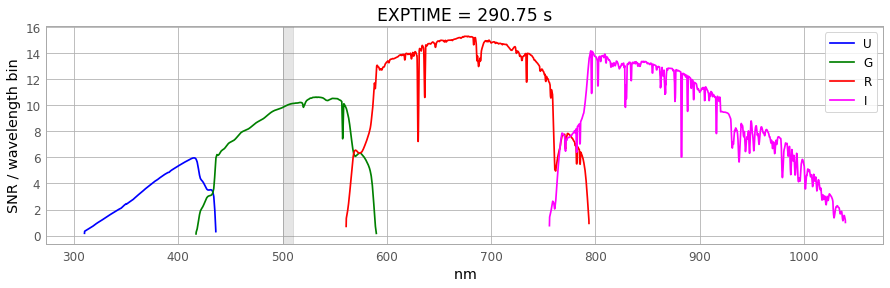

In [25]:
### THE RESULT! ###

SNR1 = SNR_from_exptime(t)

#%matplotlib notebook
fig, ax = plt.subplots(figsize=(15,4))

for k in channels:
    ax.plot(binCenters[k], SNR1[k] ,color=channelColor[k] ,label=k)

plt.ylabel('SNR / wavelength bin')
plt.legend()
ax.axvspan(SNR_range[0], SNR_range[1], alpha=0.2, color='grey') # shade user range
plt.title('EXPTIME = '+str(t))

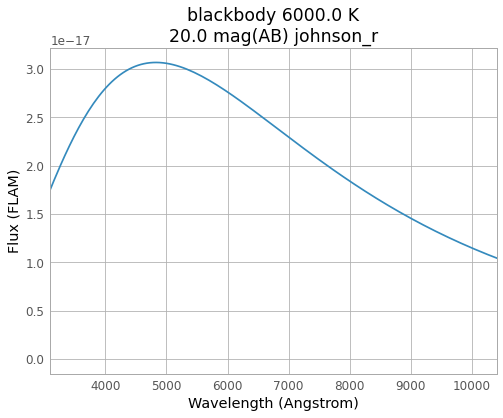

In [21]:
# Display the source spectrum
sourceSpectrum.plot(flux_unit=uu.FLAM)
plt.title(label + '\n'+ str(source['mag']) +' '+ source['magfilter'])
plt.xlim(totalRange)
p=plt.show()

In [49]:
from astropy.modeling.powerlaws import PowerLaw1D  #A*(x/x0)**(-alpha)
from astropy.modeling.functional_models import Const1D

In [64]:
from synphot import ReddeningLaw

<Quantity 620.485 nm>

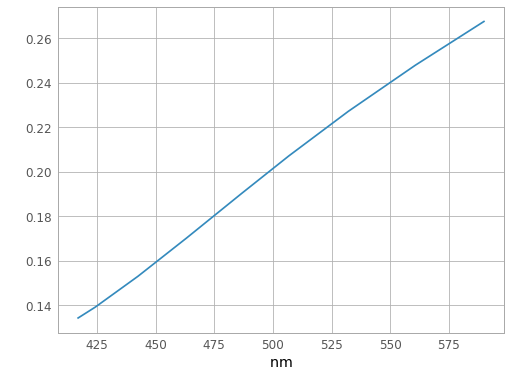

In [87]:
redlaw = ReddeningLaw.from_extinction_model('mwavg')
y = SpectralElement(redlaw.extinction_curve(.5))


plt.plot(x,y(x))

In [90]:
synphot.generate_wavelengths(500*u.nm,600*u.nm ,delta=10*u.nm ,log=False)

TypeError: only dimensionless scalar quantities can be converted to Python scalars